In [1]:
import os
import requests
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray
import bs4
import pysolar
import datetime as dt

In [4]:
data_path = os.path.join(os.getcwd(), 'data\\raw\\gml_noaa')
url = 'https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/'

In [2]:
os.chdir('/storage/dlhogan/')

'/home/dlhogan/GitHub/sublimation_of_snow/notebooks'

In [ ]:
os.chdir?

In [69]:
def download_files(url, save_path):
    os.chdir(save_path)
    r = requests.get(url)
    data = bs4.BeautifulSoup(r.text, "html.parser")
    for l in data.find_all('a', href=re.compile("\.dat$")):
        filename = l.get('href')
        outpath = os.path.join(save_path, filename)
        
        if not os.path.exists(outpath):
            print(f'Fetching {filename}...')
            url = 'https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/' + filename
            myfile = requests.get(url)
            open(filename, 'wb').write(myfile.content)

In [242]:
def met_data_formatting(fn):
    # read in data
    ckp_df = pd.read_table(fn, skiprows=2, header=None, delim_whitespace=True, parse_dates={'DateTime':[0,2,3,4,5]}, infer_datetime_format=True)
    # Convert DateTime column to datetime
    ckp_df['DateTime'] = pd.to_datetime(ckp_df['DateTime'], format='%Y %m %d %H %M')
    # Add column numbers
    col_num = [1,2,3,4,5,6,7,8,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51]
    col_num = [num - 1 for num in col_num]
    col_names = ["yyyy","jday","month","day","hour","min","dt","SZA","dw_solar","uw_solar","Direct horizontal","Diffuse",
                "dw_ir","DwCaseTemp","DwDomeTemp","uw_ir","UwCaseTemp","UwDomeTemp","UVB","PAR","NetSolar","NetIR",
                "TotalNet","AirTemp","RH","WindSpd","WindDir","Baro","SPN1_total_Avg","SPN1_diffuse_Avg"]
    ckp_df = ckp_df.rename(columns = dict(zip(col_num, col_names))) 
    # Create QC column names
    qc_col_numbers = ckp_df.columns[5::2]
    new_qc_names = [col_name + '_qc' for col_name in a.columns[3::2]]
    ckp_df = ckp_df.rename(columns = dict(zip(qc_col_numbers,new_qc_names))) 
    return ckp_df


In [7]:
filenames = [os.path.join(data_path,fn) for fn in os.listdir(data_path)]

In [237]:
int(os.path.split(filenames[0])[1].replace('ckp21','').rstrip('.dat'))

288

In [243]:
ckp = pd.DataFrame()
for file in filenames[80:120]:
    if os.path.exists(file):
        ckp = pd.concat([ckp,met_data_formatting(file)])


In [244]:
ckp

DateTime  jday      dt    SZA  dw_solar  dw_solar_qc  \
0    2022-01-03 00:00:00     3   0.000  91.18       3.0            0   
1    2022-01-03 00:01:00     3   0.017  91.35       2.6            0   
2    2022-01-03 00:02:00     3   0.033  91.52       2.3            0   
3    2022-01-03 00:03:00     3   0.050  91.69       1.9            0   
4    2022-01-03 00:04:00     3   0.067  91.86       1.6            0   
...                  ...   ...     ...    ...       ...          ...   
1435 2022-02-11 23:55:00    42  23.917  82.29      49.2            0   
1436 2022-02-11 23:56:00    42  23.933  82.47      48.8            0   
1437 2022-02-11 23:57:00    42  23.950  82.64      46.9            0   
1438 2022-02-11 23:58:00    42  23.967  82.82      46.5            0   
1439 2022-02-11 23:59:00    42  23.983  82.99      47.2            0   

      uw_solar  uw_solar_qc  Direct horizontal  Direct horizontal_qc  ...  \
0          2.6            0                3.0                     0  ...   
1          2.4            0                2.6                     0  ...   
2          2.1            0                2.3                     0  ...   
3          1.8            0                1.9                     0  ...   
4          1.6            0                1.6                     0  ...   
...        ...          ...                ...                   ...  ...   
1435      38.5            0                6.9                     0  ...   
1436      38.1            0                3.4                     0  ...   
1437      36.7            0                3.7                     0  ...   
1438      36.2            0                4.6                     0  ...   
1439      36.6            0                3.9                     0  ...   

      WindSpd  WindSpd_qc  WindDir  WindDir_qc   Baro  Baro_qc  \
0         0.7           0    297.9           0  724.8        0   
1         0.6           0    303.3           0  724.8        0   
2         0.5           0    304.8           0  724.8        0   
3         0.7           0    308.6           0  724.8        0   
4         1.3           0    305.3           0  724.8        0   
...       ...         ...      ...         ...    ...      ...   
1435      4.9           0    291.8           0  719.5        0   
1436      6.5           0    335.8           0  719.6        0   
1437      6.8           0    322.3           0  719.5        0   
1438      6.7           0    319.5           0  719.5        0   
1439      9.1           0    334.5           0  719.5        0   

      SPN1_total_Avg  SPN1_total_Avg_qc  SPN1_diffuse_Avg  SPN1_diffuse_Avg_qc  
0                0.5                  0               0.0                    0  
1                0.6                  0               0.0                    0  
2                0.4                  0               0.0                    0  
3                0.5                  0               0.0                    0  
4                0.9                  0               0.0                    0  
...              ...                ...               ...                  ...  
1435            45.7                  0              39.3                    0  
1436            44.3                  0              41.2                    0  
1437            44.3                  0              40.8                    0  
1438            44.7                  0              40.3                    0  
1439            47.0                  0              43.1                    0  

[57600 rows x 48 columns]

In [247]:

# group by average minute data
a = ckp.groupby([ckp['DateTime'].dt.date, ckp['DateTime'].dt.hour,ckp['DateTime'].dt.minute]).mean()
a.index = a.index.map(lambda idx: f'{idx[0]} {idx[1]} {idx[2]}')
a.index = pd.to_datetime(a.index, format='%Y-%m-%d %H %M', utc=True).tz_convert("US/Mountain")

<AxesSubplot:>

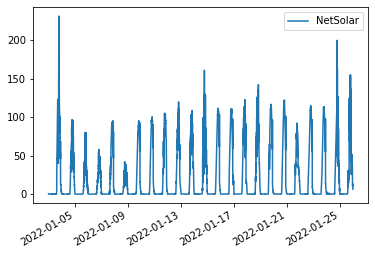

In [112]:
a[a['NetSolar'] >=0].plot(y='NetSolar')

In [140]:
# potential solar radiation at Kettle Ponds
lat = 38.941667
lon = -106.973056
timezone = dt.timezone(dt.timedelta(hours=-7))
start = dt.datetime(2022, 1, 5, tzinfo=timezone)

# Calculate radiation every hour for 90 days
nhr = 24*20
dates, altitudes_deg, radiations = pd.Series(index=range(nhr), dtype='object'), pd.Series(index=range(nhr), dtype='float64'), pd.Series(index=range(nhr),dtype='float64')
for i,ihr in enumerate(range(nhr)):
    date = start + dt.timedelta(hours=ihr)
    altitude = pysolar.solar.get_altitude(lat,lon,date)
    if altitude <= 0:
        radiation = 0.
    else:
        radiation = pysolar.radiation.get_radiation_direct(date,altitude)
    dates[i]=date
    altitudes_deg[i]=altitude
    radiations[i]=radiation

In [38]:
mask = a != -9999
a = a[mask]

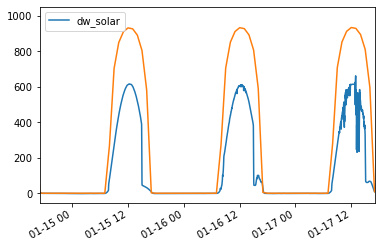

In [248]:
fig,ax = plt.subplots()
a[a['dw_solar_qc'] == 0].plot(y='dw_solar',ax=ax)
ax.plot(dates,radiations)
ax.set_xlim(dt.datetime(2022,1,15,0,0), dt.datetime(2022,1,18,0,0));

In [22]:
# !pip install windrose
import windrose

In [249]:
wind_df = a[a['WindSpd_qc'] == 0][['WindSpd','WindDir']]

In [170]:
one_day = 60*24

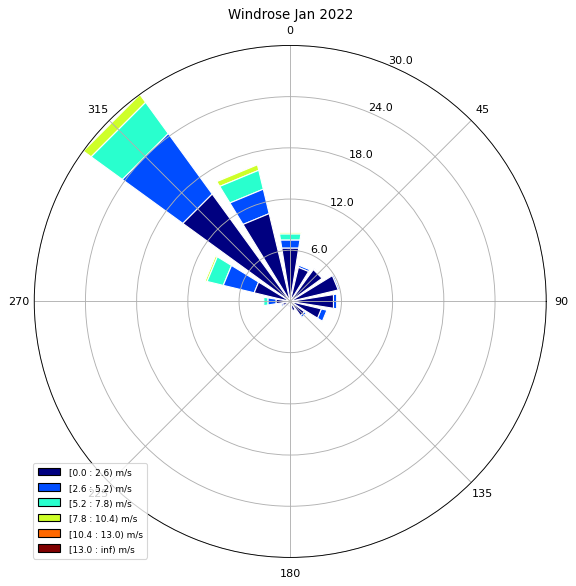

In [250]:
ax = windrose.WindroseAxes.from_ax();
ax.bar(wind_df['WindDir'], wind_df['WindSpd'], normed=True, opening=0.8, edgecolor='white');
ax.set_xticklabels((90, 45, 0, 315, 270, 225, 180, 135))
ax.set_legend(units='m/s');
ax.set_title('Windrose Jan 2022');

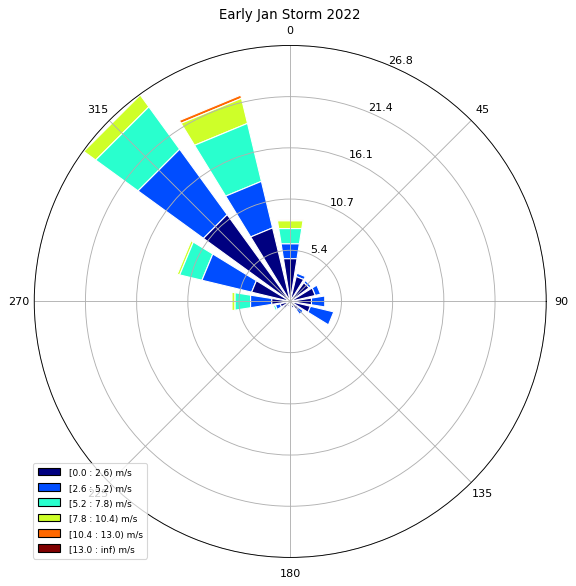

In [213]:
ax = windrose.WindroseAxes.from_ax();
ax.bar(wind_df.iloc[0:6*one_day]['WindDir'], wind_df.iloc[0:6*one_day]['WindSpd'], normed=True, opening=0.8, edgecolor='white');
ax.set_xticklabels((90, 45, 0, 315, 270, 225, 180, 135))
ax.set_legend(units='m/s');
ax.set_title('Early Jan Storm 2022');

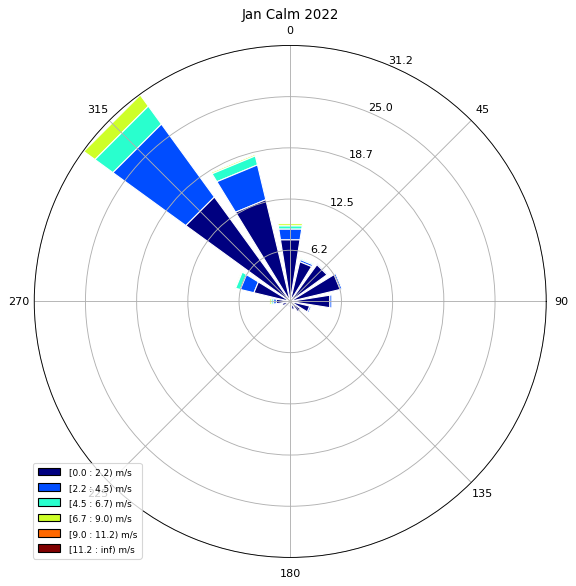

In [197]:
ax = windrose.WindroseAxes.from_ax();
ax.bar(wind_df.iloc[9*one_day:17*one_day]['WindDir'], wind_df.iloc[9*one_day:17*one_day]['WindSpd'], normed=True, opening=0.8, edgecolor='white');
ax.set_xticklabels((90, 45, 0, 315, 270, 225, 180, 135))
ax.set_legend(units='m/s');
ax.set_title('Jan Calm 2022');

In [177]:
import hvplot.pandas

In [252]:
RH = a[a['RH_qc'] == 0].hvplot(y='RH', use_index=True, width=400, height=300)
baro = a[a['Baro_qc'] == 0].hvplot(y='Baro', use_index=True, width=400, height=300)
temp = a[a['AirTemp_qc'] == 0].hvplot(y='AirTemp', use_index=True, width=400, height=300)
(RH + baro + temp)

:Layout
   .Curve.I   :Curve   [index]   (RH)
   .Curve.II  :Curve   [index]   (Baro)
   .Curve.III :Curve   [index]   (AirTemp)

<AxesSubplot:>

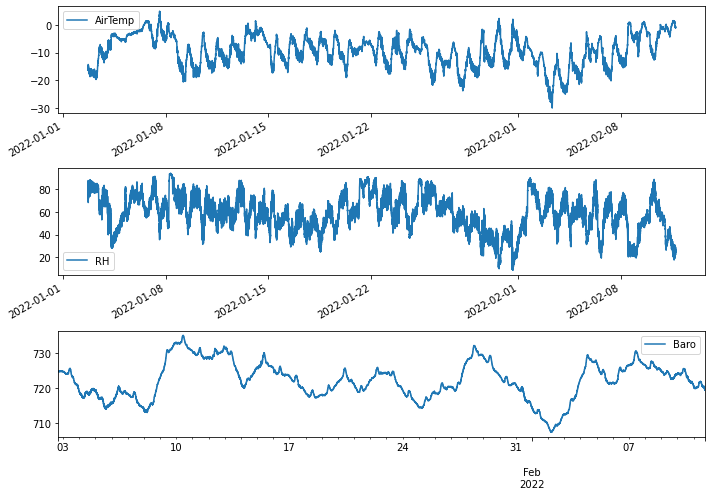

In [253]:
fig,axs = plt.subplots(nrows=3, figsize=(10,7), tight_layout=True)
a[a['AirTemp_qc'] == 0].plot(y='AirTemp', use_index=True, ax=axs[0])
a[a['RH_qc'] == 0].plot(y='RH',use_index=True, ax=axs[1])
a[a['Baro_qc'] == 0].plot(y='Baro',use_index=True, ax=axs[2])
# for ax in axs:
#     ax.set_xlim(dt.datetime(2022,1,15,0,0), dt.datetime(2022,1,18,0,0));

In [254]:
temp = a[a['AirTemp_qc'] == 0].hvplot(y='AirTemp', grid=True)
solar = a[a['NetSolar_qc'] == 0].hvplot(y='dw_solar', grid=True)
netir = a[a['NetIR_qc'] == 0].hvplot(y='NetIR', grid=True)
totalnet = a[a['TotalNet_qc'] == 0].hvplot(y='TotalNet', grid=True)
(solar + netir + totalnet).cols(1)

:Layout
   .Curve.I   :Curve   [index]   (dw_solar)
   .Curve.II  :Curve   [index]   (NetIR)
   .Curve.III :Curve   [index]   (TotalNet)

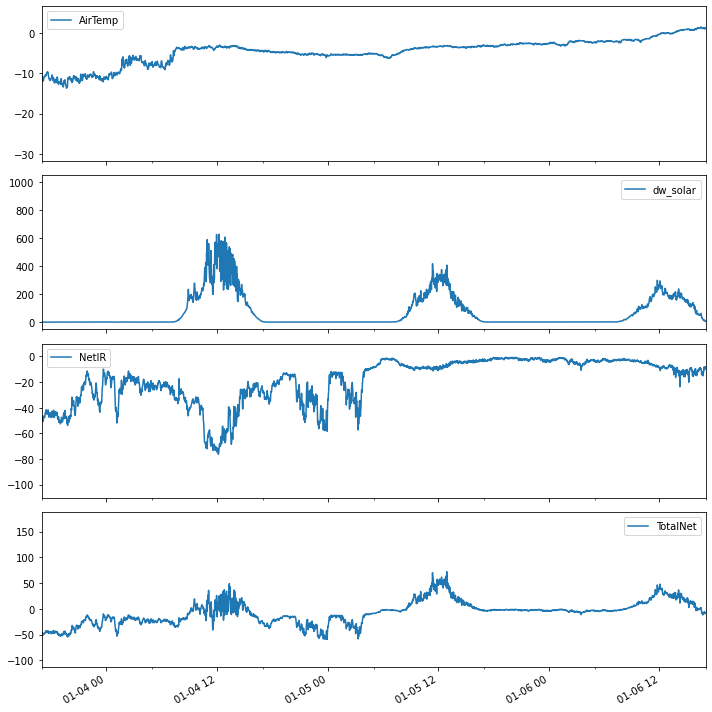

In [257]:
fig,axs = plt.subplots(nrows=4, figsize=(10,10), sharex=True, tight_layout=True)
a[a['NetSolar_qc']==0].plot(y='dw_solar',ax=axs[1])
a[a['NetIR_qc']==0].plot(y='NetIR',ax=axs[2])
a[a['AirTemp_qc']==0].plot(y='AirTemp',ax=axs[0])
a[a['TotalNet_qc']==0].plot(y='TotalNet',ax=axs[3])
for ax in axs:
    ax.set_xlim(dt.datetime(2022,1,4,0,0), dt.datetime(2022,1,7,0,0));



In [ ]:
# Try using with hvplot.pandas
# Convert to xarray? Maybe later for more analysis

C:\Users\dlhogan\AppData\Local\Temp/ipykernel_14096/4084774834.py:2: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  a.loc[dt.datetime(2022,1,31,7,0):dt.datetime(2022,2,1,7,0)][a['AirTemp_qc']==0].hist(column='AirTemp',bins=100,ax=ax);
C:\Users\dlhogan\AppData\Local\Temp/ipykernel_14096/4084774834.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  a.loc[dt.datetime(2022,1,31,7,0):dt.datetime(2022,2,1,7,0)][a['AirTemp_qc']==0].hist(column='AirTemp',bins=100,ax=ax);


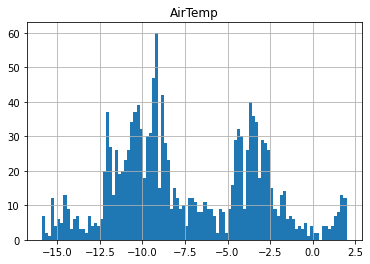

In [270]:
fig,ax = plt.subplots()
a.loc[dt.datetime(2022,1,31,7,0):dt.datetime(2022,2,1,7,0)][a['AirTemp_qc']==0].hist(column='AirTemp',bins=100,ax=ax);
# ax.set_ylabel('Temperature (C)')
# ax.set_title('Radsys temperature')
# ax.set_xlim(dt.datetime(2022,1,31,7,0), dt.datetime(2022,2,1,7,0));

In [225]:
a.columns

Index([                'jday',                   'dt',                  'SZA',
                'dw_solar_qc',                      9,          'uw_solar_qc',
                           11, 'Direct horizontal_qc',                     13,
                 'Diffuse_qc',                     15,             'dw_ir_qc',
                           17,        'DwCaseTemp_qc',                     19,
              'DwDomeTemp_qc',                     21,             'uw_ir_qc',
                           23,        'UwCaseTemp_qc',                     25,
              'UwDomeTemp_qc',                     27,               'UVB_qc',
                           29,               'PAR_qc',                     31,
                'NetSolar_qc',                     33,             'NetIR_qc',
                           35,          'TotalNet_qc',                     37,
                 'AirTemp_qc',                     39,                'RH_qc',
                           41,           'WindSpd_qc